# Instalación de librerias.

In [ ]:
!pip install boto3
!pip install tensorflow
!pip install tensorflow --upgrade

# Activo la libreria de drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Verificacion tecnica del sistema.



In [ ]:
from platform import python_version
import tensorflow as tf

print("Version de python: " + python_version())
print("Version de tensorflow: " + tf.__version__)

Version de python: 3.7.10
Version de tensorflow: 2.5.0


# Carga del dataset.

In [ ]:
from glob import glob

# path_train = '/content/drive/MyDrive/AgricultureVisión/Data/dataset-mineria-tfrecord/dataset-estadistica-train-rgb/'
# train_filenames=(glob(path_train+'*.tfrecords'))
# train_filenames
train_filenames = '/content/drive/MyDrive/AgricultureVisión/Data/dataset-mineria-tfrecord/dataset-mineria-train-rgb.tfrecords'

In [ ]:
# path_test = '/content/drive/MyDrive/AgricultureVisión/Data/dataset-mineria-tfrecord/dataset-estadistica-test-rgb/'
# test_filenames=(glob(path_test+'*.tfrecords'))
# test_filenames
test_filenames = '/content/drive/MyDrive/AgricultureVisión/Data/dataset-mineria-tfrecord/dataset-mineria-test-rgb.tfrecords'

In [ ]:
import os
import pandas as pd

pathClases = '/content/drive/MyDrive/AgricultureVisión/Data/dataset-estadistica/test/rgb'

classes = os.listdir(pathClases)

aux = []
for _idx, _valor in enumerate(classes):
    Class = _valor
    label = (classes.index(_valor))
    aux.append([Class, label])
    
csv = pd.DataFrame(aux, columns=['Class','label'])
csv.head(10)

,Class,label
0,double_plant,0
1,drydown,1
2,nutrient_deficiency,2
3,planter_skip,3
4,endrow,4
5,storm_damage,5
6,water,6
7,weed_cluster,7
8,waterway,8


In [ ]:
#Tamaño de las imágenes en los archivos TFRecord
IMAGE_SIZE=[512,512]
CLASSES=list(csv['Class'])
print(CLASSES)
NO_OF_CLASSES=len(CLASSES)
NO_OF_CLASSES

['double_plant', 'drydown', 'nutrient_deficiency', 'planter_skip', 'endrow', 'storm_damage', 'water', 'weed_cluster', 'waterway']


9

In [ ]:
# Funciones utilies.
import math
from matplotlib import pyplot as plt
import tensorflow as tf

AUTO = tf.data.experimental.AUTOTUNE
ignore_order = tf.data.Options()
ignore_order.experimental_deterministic = False

def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convertir la imagen en flotantes en el rango [0, 1]
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # tamaño explícito necesario para el TPU
    return image

def read_tfrecord(example):
    features={
            "image_raw": tf.io.FixedLenFeature([], tf.string),
            "label": tf.io.FixedLenFeature([], tf.int64),}
    example = tf.io.parse_single_example(example, features)
    image = decode_image(example['image_raw'])
    label = tf.cast(example['label'], tf.int32)
    return image, label

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct
                                
def load_dataset(filenames,shuffle,BATCH_SIZE,repeat=False):
    # Leer desde TFRecords. Para un rendimiento óptimo, lea de varios
    # Archivos TFRecord a la vez y establecer la opción experimental_deterministic = False
    # para permitir optimizaciones que alteren el orden.
    dataset = tf.data.TFRecordDataset(filenames,num_parallel_reads=AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_tfrecord)
    dataset = dataset.prefetch(AUTO)
    dataset = dataset.shuffle(shuffle)
    if(repeat):
        dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

def display_batch_of_images(databatch, predictions=None):
    """Esto funcionará con:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-cuadrado: esto eliminará los datos que no encajen en un cuadrado o rectángulo.
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # tamaño y espaciado
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # mostrar
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # fórmula mágica probada para trabajar de 1x1 a 10x10 imágenes
        subplot = display_one(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #diseño
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # cadena binaria en este caso, se trata de cadenas de identificación de imágenes.
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # Si no hay etiquetas, sólo los ID de las imágenes, devuelve None para las etiquetas (este es el caso de los datos de prueba)
    return numpy_images, numpy_labels

def display_one(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

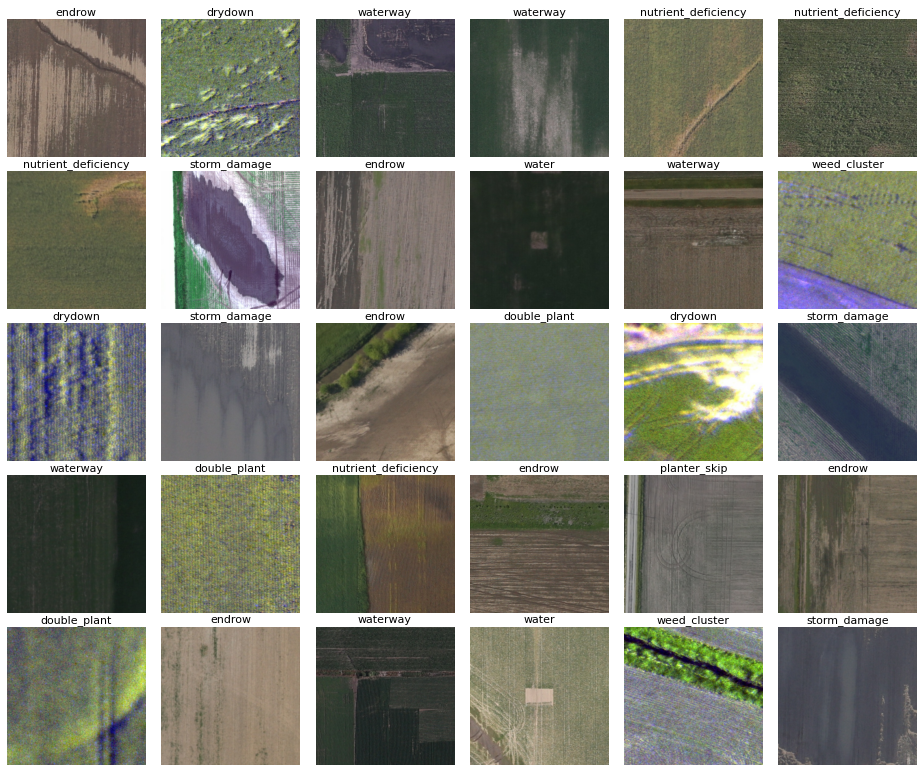

In [ ]:
#Mostrar algunas imágenes del conjunto de datos de entrenamiento.
d=load_dataset(train_filenames,5000,30)
train_batch=iter(d)
display_batch_of_images(next(train_batch))

In [ ]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])  # Detectar TPU
  print('TPU encontrada ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: TPU no encontrada!')

TPU encontrada  ['10.98.97.98:8470']


In [ ]:
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

INFO:tensorflow:Initializing the TPU system: grpc://10.98.97.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.98.97.98:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
img_size = 512
num_classes = 9
num_images = 70545

with tpu_strategy.scope():
  input = tf.keras.layers.Input(shape=(img_size, img_size, 3))
  model = tf.keras.applications.ResNet50(include_top=False, input_tensor=input, weights="imagenet")

  # Freeze the pretrained weights
  model.trainable = False

  # Rebuild top
  x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
  x = tf.keras.layers.BatchNormalization()(x)

  top_dropout_rate = 0.2
  x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
  output = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")(x)

  # Compile
  model = tf.keras.Model(input, output, name="ResNet50")
  model.summary()
  model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
BATCH_SIZE = 32
shuffle=5000
train_dataset=load_dataset(train_filenames,shuffle,BATCH_SIZE,True)
test_dataset=load_dataset(test_filenames,int(shuffle*0.5),BATCH_SIZE)

In [ ]:
history = model.fit(train_dataset,validation_data=test_dataset, batch_size=32, epochs=3, steps_per_epoch=math.ceil(num_images/32))

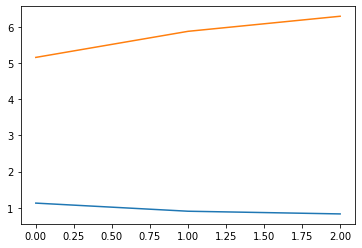

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

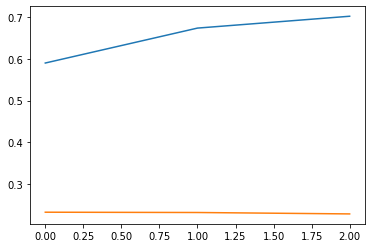

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])

In [ ]:
from tensorflow.keras.models import load_model

model.save('/content/drive/MyDrive/AgricultureVisión/models/model_resnet50_1.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
from keras.models import load_model

path_model = '/content/drive/MyDrive/AgricultureVisión/models/model_resnet50_1.h5'

model = load_model(path_model)

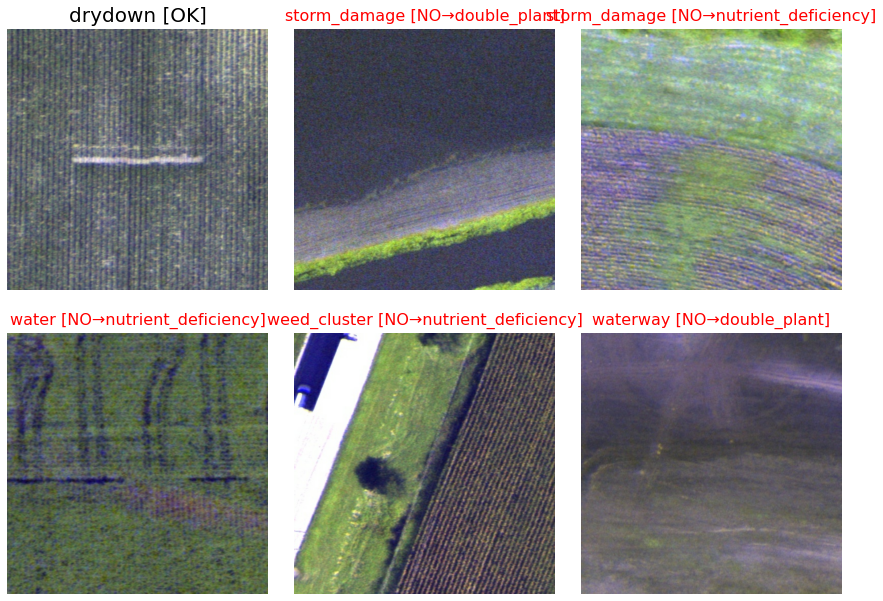

In [ ]:
#Display predicted images in test set
valid=load_dataset(test_filenames,5000,6)
valid=next(iter(valid))
result=model.predict(valid[0])
display_batch_of_images(valid,predictions=tf.argmax(result,axis=1))